In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\dilly\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [4]:
import datetime

In [5]:
dataset = pd.read_csv("DIS_stock_price.csv", index_col="Date", parse_dates=["Date"])
print(dataset.head())

            Open Price  High Price  Low Price  Close Price      Volume
Date                                                                  
1999-11-01       25.31       26.06      24.94        25.69   7585800.0
1999-11-02       25.56       26.31      25.50        26.25   6240800.0
1999-11-03       27.38       27.38      26.69        26.88   8196800.0
1999-11-04       27.75       29.00      26.00        26.50  13492400.0
1999-11-05       25.50       25.50      24.06        24.31  26165000.0


In [6]:
print(dataset.describe())

        Open Price   High Price    Low Price  Close Price        Volume
count  6281.000000  6281.000000  6281.000000  6281.000000  6.281000e+03
mean     67.436753    68.087816    66.735660    67.428240  9.810510e+06
std      44.669931    45.029558    44.237155    44.624743  6.085865e+06
min      13.800000    14.100000    13.480000    13.770000  1.487900e+06
25%      28.910000    29.380000    28.550000    29.000000  6.380600e+06
50%      43.610000    44.080000    43.260000    43.790000  8.340051e+06
75%     103.220000   104.150000   102.100000   103.260000  1.142185e+07
max     200.185000   203.020000   195.400000   201.910000  1.166250e+08


In [7]:
dataset.isna().sum()

Open Price     0
High Price     0
Low Price      0
Close Price    0
Volume         0
dtype: int64

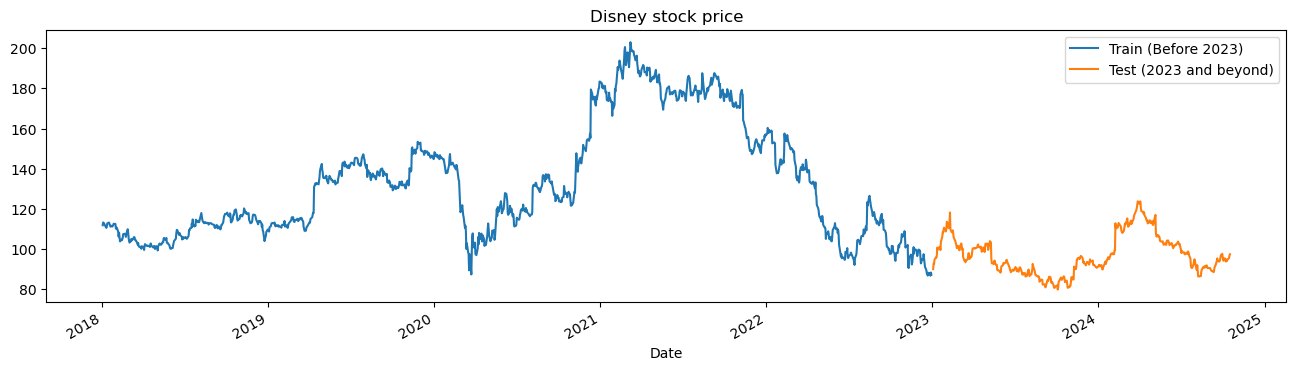

In [8]:
tstart = 2018
tend = 2022

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High Price"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High Price"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Disney stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)


In [9]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High Price"].values
    test = dataset.loc[f"{tend+1}":, "High Price"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)
print(training_set)

[111.81  113.19  113.    ...  86.69   88.242  87.12 ]


In [10]:
dataset.loc[f"{tend+1}":, "High Price"]

Date
2023-01-03    89.9716
2023-01-04    92.7450
2023-01-05    92.4800
2023-01-06    94.6900
2023-01-09    95.7000
               ...   
2024-10-11    94.6100
2024-10-14    95.1900
2024-10-15    95.6500
2024-10-16    96.7900
2024-10-17    97.3300
Name: High Price, Length: 451, dtype: float64

In [11]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)


In [12]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [13]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

C:\Users\dilly\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0265
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0029
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0021
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0019
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0015
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0015
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0013
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010    
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0010
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 9.8901e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0011
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8.7

In [15]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0357
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0018
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0023
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0014
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0014
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0012
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0010
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0014
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0012
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0011
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 9.0356e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.4007e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.0

In [17]:
dataset_total = dataset.loc[:,"High Price"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
#maintain for later prediction
X_values = X_test

In [22]:
#test set prediction
inverted_predicted_stock_price_lstm = model_lstm.predict(X_test)
inverted_predicted_stock_price_gru = model_gru.predict(X_test)
#inverse transform the values
predicted_stock_price_lstm = sc.inverse_transform(inverted_predicted_stock_price_lstm)
predicted_stock_price_gru = sc.inverse_transform(inverted_predicted_stock_price_gru)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [23]:
datetimes = dataset.loc[f"{tend+1}":, "High Price"].keys()
dateOfTestStart = datetimes[0].strftime("%m/%d/%Y")
dateOfTestEnd = datetimes[-1].strftime("%m/%d/%Y")
futurePredicts = 0
def comparePlots(test, predicted,colors):
    plt.plot(test, color="gray", label="Real")
    for n in range(len(predicted)):
        plt.plot(predicted[n], color=colors[n], label=f"Predicted Plot {n+1}")
    plt.title("Disney Stock Price Prediction")
    plt.xlabel(f"Days open since {dateOfTestStart}")
    plt.ylabel("Disney Stock Price")
    plt.legend()
    plt.show()

def plot_predictions(values,color,label):
    plt.plot(values, color=color, label="Predicted")
    plt.title("Disney Stock Price Prediction")
    plt.xlabel(f"Days open since {dateOfTestEnd}")
    plt.ylabel("Disney Stock Price")
    plt.legend()
    plt.show()
    
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

def predict_next_stock_price(predicted,numPredicts,prev):
    next_price_inverted = model_lstm.predict(prev)
    newX = next_price_inverted.reshape(1,60,1)
    X_Values=np.append(predicted,newX,axis=0)
    next_price = sc.inverse_transform(next_price_inverted)
    numPredicts+=1
    print(f"Predicted price {numPredicts} open days after {dateOfTestEnd}: {next_price[0][0]}")
    return numPredicts,X_Values,next_price[0][0]

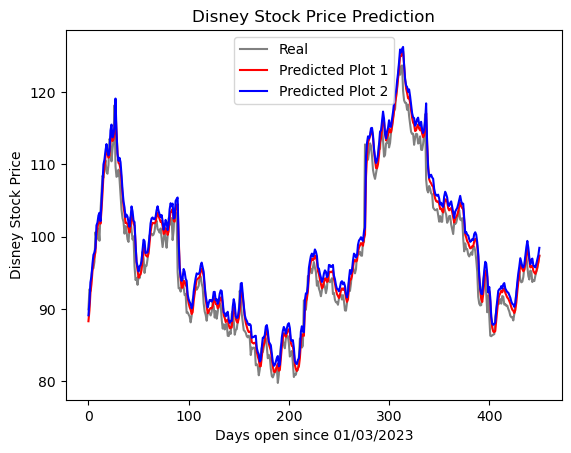

In [24]:
comparePlots(test_set,[predicted_stock_price_lstm,predicted_stock_price_gru],["red","blue"])

In [25]:
return_rmse(test_set,predicted_stock_price_lstm)
return_rmse(test_set,predicted_stock_price_gru)

The root mean squared error is 2.15.
The root mean squared error is 2.60.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted price 1 open days after 10/17/2024: 101.9183578491211
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted price 2 open days after 10/17/2024: 102.66841125488281
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted price 3 open days after 10/17/2024: 101.48444366455078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted price 4 open days after 10/17/2024: 100.12190246582031
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted price 5 open days after 10/17/2024: 97.7991943359375
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted price 6 open days after 10/17/2024: 95.96805572509766
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted price 7 open days after 10/17/2024: 96.72438049316406
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted price 8 open days after 10/17/2024: 97.9531021118164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted price 9 open days after 10/17/2024: 98.65776062011719
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted price 10 open days after 10/17/20

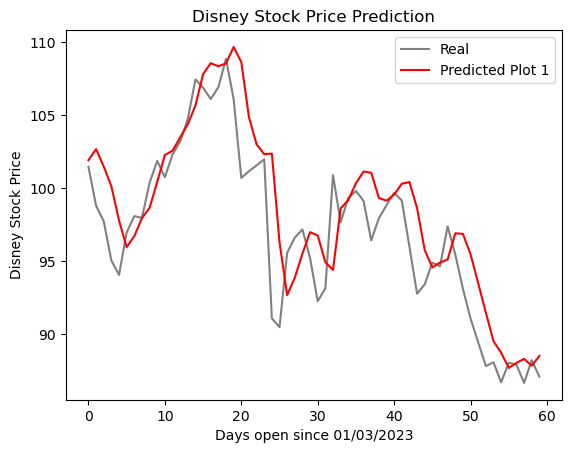

In [28]:
futurePredicts = 0
newPredicts = []
tempX = X_train
for n in range(60):
    prev = tempX[-60:]
    futurePredicts,tempX,newPrice = predict_next_stock_price(tempX,futurePredicts,prev)
    newPredicts.append(newPrice)
comparePlots(training_set[-futurePredicts:],[newPredicts],['red'])

In [30]:
return_rmse(training_set[-futurePredicts:],newPredicts)

The root mean squared error is 8.88.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted price 1 open days after 10/17/2024: 92.50167846679688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted price 2 open days after 10/17/2024: 91.38463592529297
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted price 3 open days after 10/17/2024: 90.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted price 4 open days after 10/17/2024: 92.08939361572266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted price 5 open days after 10/17/2024: 93.70951843261719
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted price 6 open days after 10/17/2024: 95.12997436523438
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted price 7 open days after 10/17/2024: 95.38790893554688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted price 8 open days after 10/17/2024: 94.44332885742188
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted price 9 open days after 10/17/2024: 92.32488250732422
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted price 10 open days after 10/17/2024: 92.46

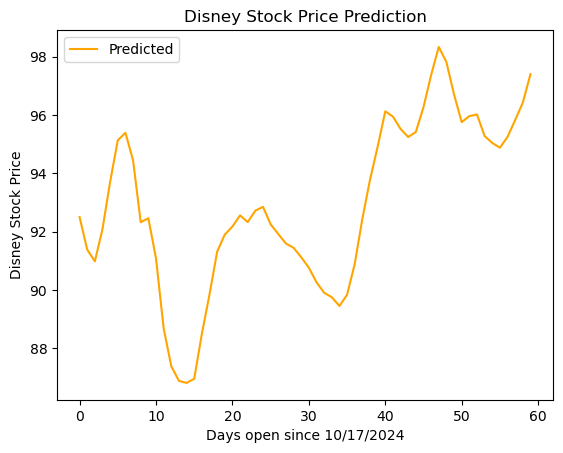

In [29]:
futurePredicts = 0
newPredicts = []
for n in range(60):
    prev = X_values[-60:]
    futurePredicts,X_values,newPrice = predict_next_stock_price(X_values,futurePredicts,prev)
    newPredicts.append(newPrice)
plot_predictions(newPredicts,"orange","Predictions")

In [31]:
def convertDate(startDate,opendays,holidays):
    weeks = int(opendays/5)
    leftover = opendays%5
    totaldays = weeks*7 + leftover + holidays
    finalDate = startDate + datetime.timedelta(days=totaldays)
    return finalDate.strftime("%m/%d/%Y")

print(convertDate(datetimes[-1],60,1))

01/10/2025
